**<h1>Introduction</h1>**
<hr>

**About Dataset**
---

This is **Fast Food Classification** data set containing images of **5 different** types of **fast food**. Each directory represents a **class**, and **each class** represents a **food type**. The Classes are $:$
* **Burger**
* **Donut**
* **Hot Dog**
* **Pizza**
* **Sandwich**

The data set is **divided into 3 parts**, the **Tensorflow records**, **Training data set** and **Validation data set**. 
* The tensorflow records directory is further **divided into 2 parts**, the **training images** and the **validation images**.These images are **resized to 256 by 256 pixels**. No other augmentation is applied. While loading the tensorflow records files, **you can apply any augmentation you want**.
 * **Training Images** : Contains **7,500** training images, with each class having **1,500 images**.
 * **Validation Images** : Contains **2,500** validation images, with each class having **500 images**.


* Unlike the **Tensorflow records data**, the **Training data and validation data** contains **direct images**. These are raw images. So **any kind of augmentation**, and specially **resizing**, can be applied on them. 
 * **Training Data** : This directory contains **5 subdirectories**. Each **directory representing a class**. Each **class have 1,500 training images**.
 * **Validation Data** : This directory also contains **5 subdirectories**. Each **directory representing a class**. Each **class have 500 images for monitoring model's performance**.


**About Notebook**
---

This notebook is **further divided into multiple sections** : 
1. **Imports**
 * Contains all the **modules** used in the **notebook**.

2. **Data Distribution**
 * Understanding the **data/class distribution.**

3. **Loading Data**
 * Loading the **fast food classification data** using **keras ImageDataGenerator**.

4. **Data Visulaization**
 * **Visualizing** the loaded data set to **better understand the problem and data set**.

5. **TF Records**
 * Loading the **tensor flow records files and visualizing the data set.**

6. **Model Architecture**
 * Creating a **model architecture** that can perfectly fit this **data set**.

7. **Predictions**
 * After **creating and tuning the model**, it's time to look at the **model's predictions**.

# **Imports**

Below are all the **imports** that are required in the **notebook**.

In [1]:
# Common
import os
import numpy as np
import tensorflow as tf

# TFRecords Loading
from tensorflow import io
from tensorflow import data as tfd
from tensorflow import train as tft
from tensorflow import image as tfi

# Data Loading 
from keras.preprocessing.image import ImageDataGenerator  as IDG

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Models 
from keras.layers import Dense, GlobalAveragePooling2D as GAP, Dropout
from keras.models import load_model, Sequential

# Pre Trained Models
from tensorflow.keras.applications import ResNet50V2, InceptionV3, Xception, ResNet50, ResNet152V2

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

Enable the auto mixed precision for better training speed.

In [2]:
os.environ['ENABLE_AUTO_MIXED_PRECISION']  = '1'

# **Data Distribution**

Before loading the data, it is **important to understand the data distribution and the class distribution**. Because our **final model** can be **affected** by the **class distribution**.

In [3]:
# Specify the root path.
train_path = '../input/fast-food-classification-dataset/Fast Food Data/Training Data/'
valid_path = '../input/fast-food-classification-dataset/Fast Food Data/Validation Data/'

In [4]:
# Collecte the class names.
class_names = sorted(os.listdir(train_path))
n_classes = len(class_names)

# Print
print("No. Classes : {}".format(n_classes))
print("Classes     : {}".format(class_names))

No. Classes : 5
Classes     : ['Burger', 'Donut', 'Hot Dog', 'Pizza', 'Sandwich']


We were already aware that our **data set consist of five classes**. Let's have a look at the **Class Distribution**.

In [5]:
# Calculate the class distribution
class_dis = [len(os.listdir(train_path + name)) for name in class_names]

# Virtualize class distribution
fig = px.pie(names=class_names, values=class_dis, hole=0.3)
fig.update_layout({"title":{'text':"Training Class Distribution", 'x':0.48}})
fig.show()

fig = px.bar(x=class_names, y=class_dis, color=class_names)
fig.show()

All the classes are **equally distributed** throughout the **training data**. This is a **good sign**, because **this ensures that our model cannot be biased towards a particular class**.

---
Let's also look at the **validation class distribution**, Because this distribution can **affect how we perceive the model's performance**.

In [6]:
# Calculate the class distribution
class_dis = [len(os.listdir(valid_path + name)) for name in class_names]

# Virtualize class distribution
fig = px.pie(names=class_names, values=class_dis, hole=0.3)
fig.update_layout({"title":{'text':"Validation Class Distribution", 'x':0.48}})
fig.show()

fig = px.bar(x=class_names, y=class_dis, color=class_names)
fig.show()

**Great!** Even in the **validation data**, all classes are **equally distributed**. So the **model predictions cannot be just random guesses**.

# **Data Loading**

We are aware about the class distribution. It's time to **load the data**.

In [7]:
# Initialize image data generator
train_gen = IDG(rescale=1./255, rotation_range=10, horizontal_flip=True, vertical_flip=False)
valid_gen = IDG(rescale=1./255)

# Load the datasets
train_ds = train_gen.flow_from_directory(train_path, shuffle=True, batch_size=64, target_size=(256,256), class_mode='binary')
valid_ds = valid_gen.flow_from_directory(valid_path, shuffle=True, batch_size=32, target_size=(256,256), class_mode='binary')

Found 7500 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.


Setting a higher batch size does not affect the model's performance, but it do affects the GPU usage. **For better utilization of the GPU, a higher batch size is set for the training data**.

# **Data Visulization**

**Before framing the final model**, we need to have a **look at the data set** so that we can decide the **model configurations**.

In [8]:
def show_images(data, class_names=class_names, GRID=[3,6], figsize=(25,15), model=None):
    
    # Plot configurations
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=figsize)
    
    n=1
    for images, labels in iter(data):
        
        # Select a random image and label.
        idx = np.random.randint(len(images))
        image, label = images[idx], class_names[int(labels[idx])]
        
        # Plot image
        plt.subplot(n_rows, n_cols, n)
        title = f"True : {label}"
        if model is not None:
            pred = class_names[np.argmax(model.predict(image[np.newaxis,...])[0])]
            title = f"True : {label}\nPred : {pred}"
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        
        n+=1
        if n>=(n_images+1):
            break
            
    plt.show()

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



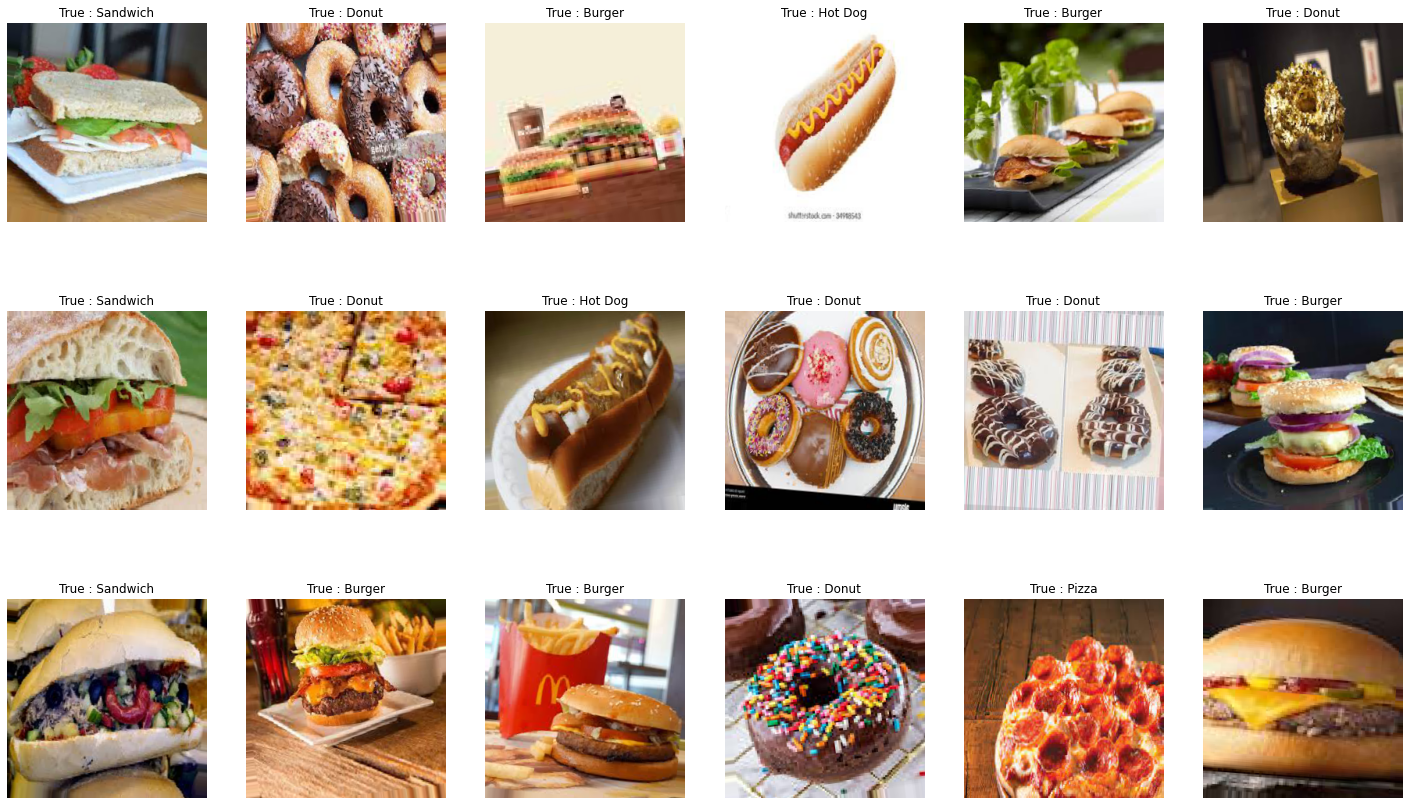

In [9]:
show_images(data=train_ds)

# **TFRecords Loading**

The below functions will **decode the data** and apply little bit of **data augmentation**.

In [10]:
def process_data(image):
    image = tfi.decode_jpeg(image, channels=3)
    image = tfi.random_brightness(image, max_delta=0.2)
    image = tf.cast(image, tf.float32)/255.
    return image

def cvt_to_image_label(example):
    ground_truth = {
        'label':io.FixedLenFeature([], tf.int64),
        'image':io.FixedLenFeature([], tf.string)
    }

    example = io.parse_single_example(example, ground_truth)
    images, labels = example['image'], example['label']
    images = process_data(images)
    return images, labels

In [11]:
# Specify the Path
file_pattern = '../input/fast-food-classification-dataset/Fast Food Data/TFRecords Data/Training Images/*.tfrecord'
files = tfd.Dataset.list_files(file_pattern)

# Load The Data
data = tfd.TFRecordDataset(files)
data = data.map(cvt_to_image_label, num_parallel_calls=tfd.AUTOTUNE)
data = data.cache().repeat(1).shuffle(2048)
train_tf_ds = data.batch(64, drop_remainder=True).prefetch(tfd.AUTOTUNE)

2022-11-13 15:27:07.908276: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Similarly, let's load the **validation data**.

In [12]:
# Specify the Path
file_pattern = '../input/fast-food-classification-dataset/Fast Food Data/TFRecords Data/Validation Images/*.tfrecord'
files = tfd.Dataset.list_files(file_pattern)

# Load The Data
data = tfd.TFRecordDataset(files)
data = data.map(cvt_to_image_label, num_parallel_calls=tfd.AUTOTUNE)
data = data.cache().repeat(1).shuffle(2048)
valid_tf_ds = data.batch(64, drop_remainder=True).prefetch(tfd.AUTOTUNE)

**Processing and loading data** using **Tensorflow records** allow **better utilization of memory**, as well as the **tensorflow environment**.

# **Data Visualization**

Just like we plotted the images for **Image Data Generator data**, let's plot the images for the **Tensorflow Records**.

2022-11-13 15:27:14.104886: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-13 15:27:24.105493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2018 of 2048
2022-11-13 15:27:24.245790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-11-13 15:27:30.718329: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


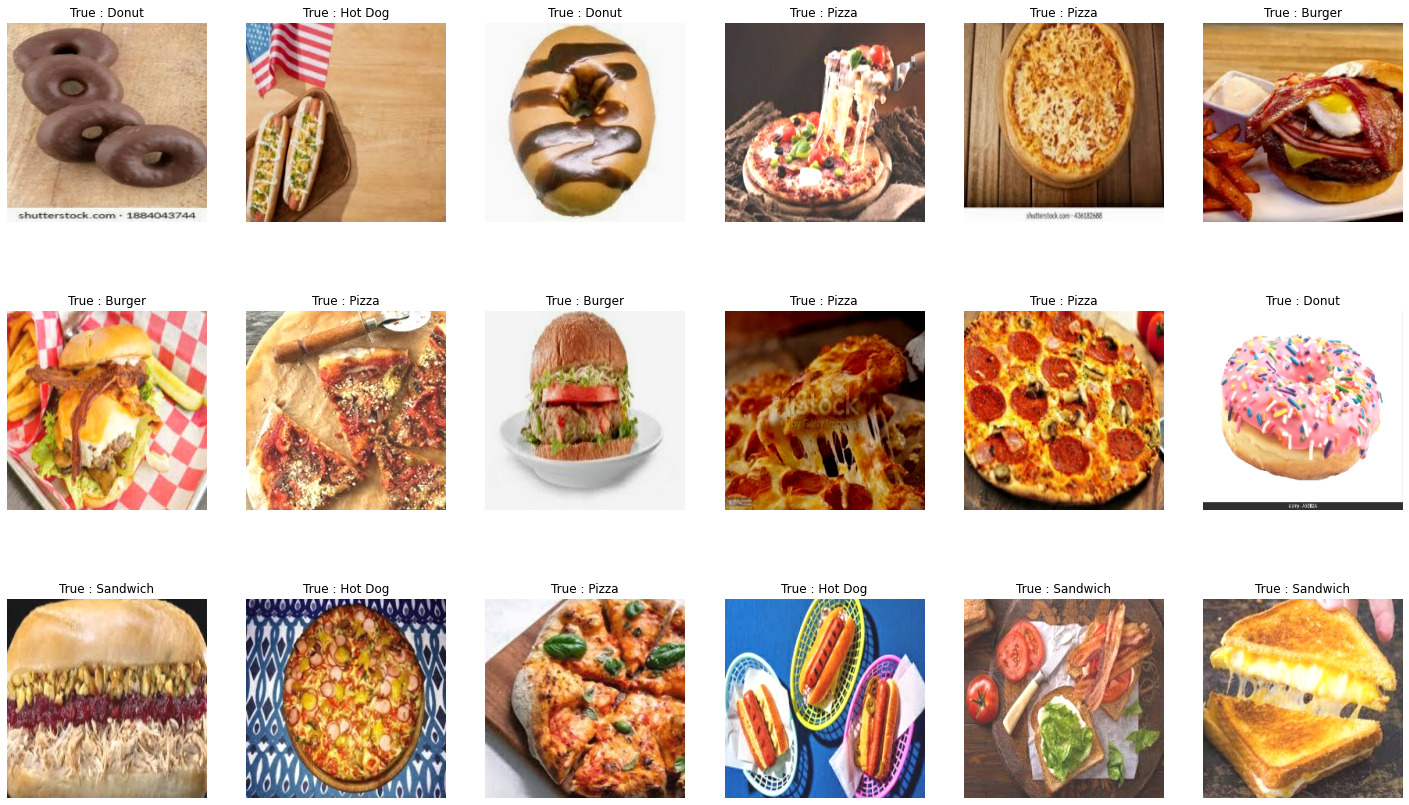

In [13]:
show_images(data=train_tf_ds)

2022-11-13 15:27:46.027080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1979 of 2048
2022-11-13 15:27:46.358154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


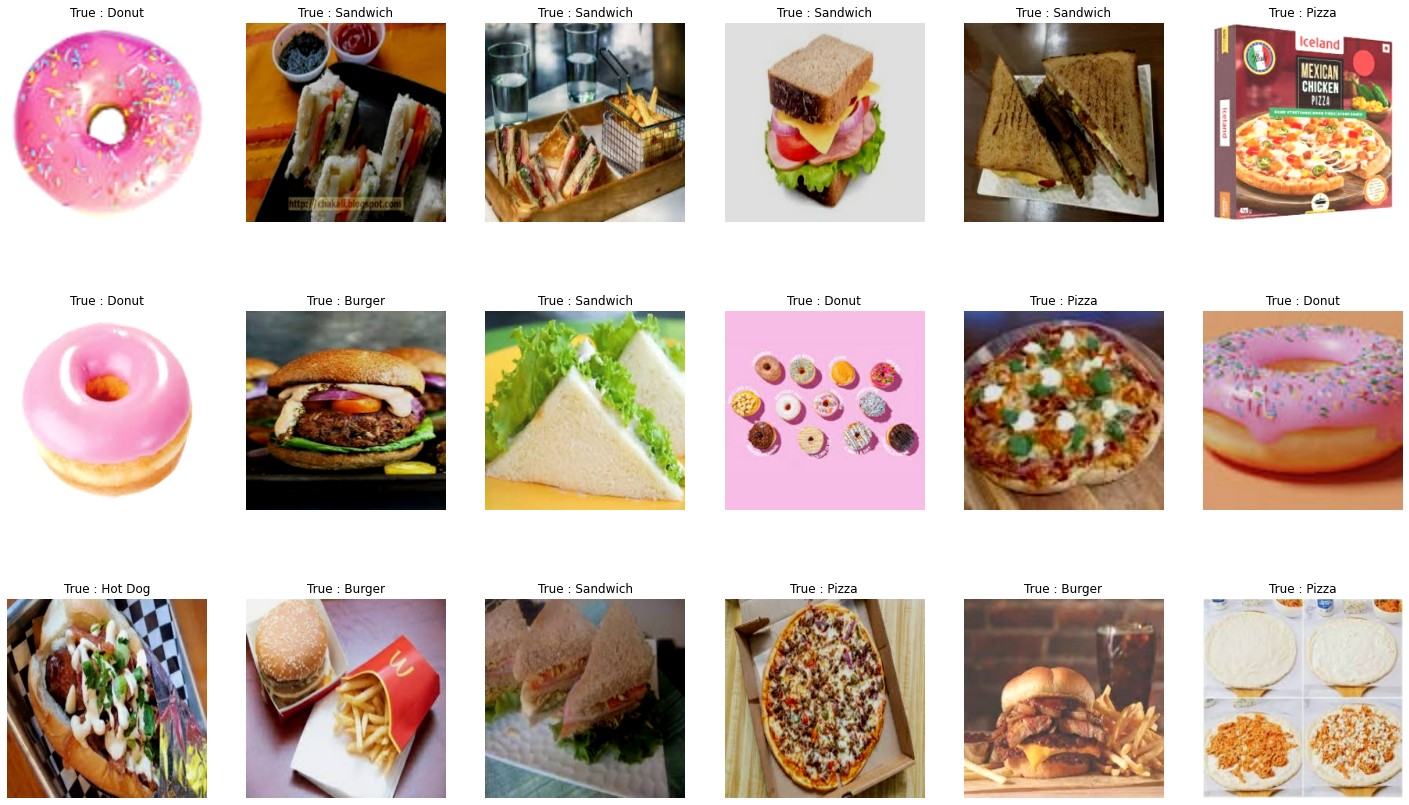

In [14]:
show_images(data=valid_tf_ds)

The **only difference** between this data and the original data is that the **tensorflow records** data is already **resized to 256 by 256 pixels**.

# **Model**

Let's focus on building the **perfect model architecture** for this **data set**.

In [15]:
# Base Model
base = ResNet50V2(include_top=False, input_shape=(256,256,3))
base.trainable = False

# Model Architecture
model = Sequential([
    base, GAP(),
    Dense(1024, kernel_initializer='he_normal', activation='relu'),
    Dropout(0.4),
    Dense(n_classes, activation='softmax')
])

# Callbacks
cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('food-classifier.h5', save_best_only=True)
]

# Compile
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
    metrics=['accuracy']
)

# Train
# model.fit(train_tf_ds, validation_data-valid_tf_ds, epochs=100, callbacks=cbs)

94683136/94668760 [==============================] - 1s 0us/step


# **Load Model**

I have already trained in the model, and the **model weights** are **available in the associated data set**. So let's **load those weights**.

In [16]:
model = load_model('../input/fast-food-classifier-resnet50v2/Fast-Food-Classifier.h5')
model.summary()

Model: "resnet50v2-v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 5125      
Total params: 25,668,101
Trainable params: 2,103,301
Non-trainable params: 23,564,800
_________________________________________________________________


# **Model Prediction**

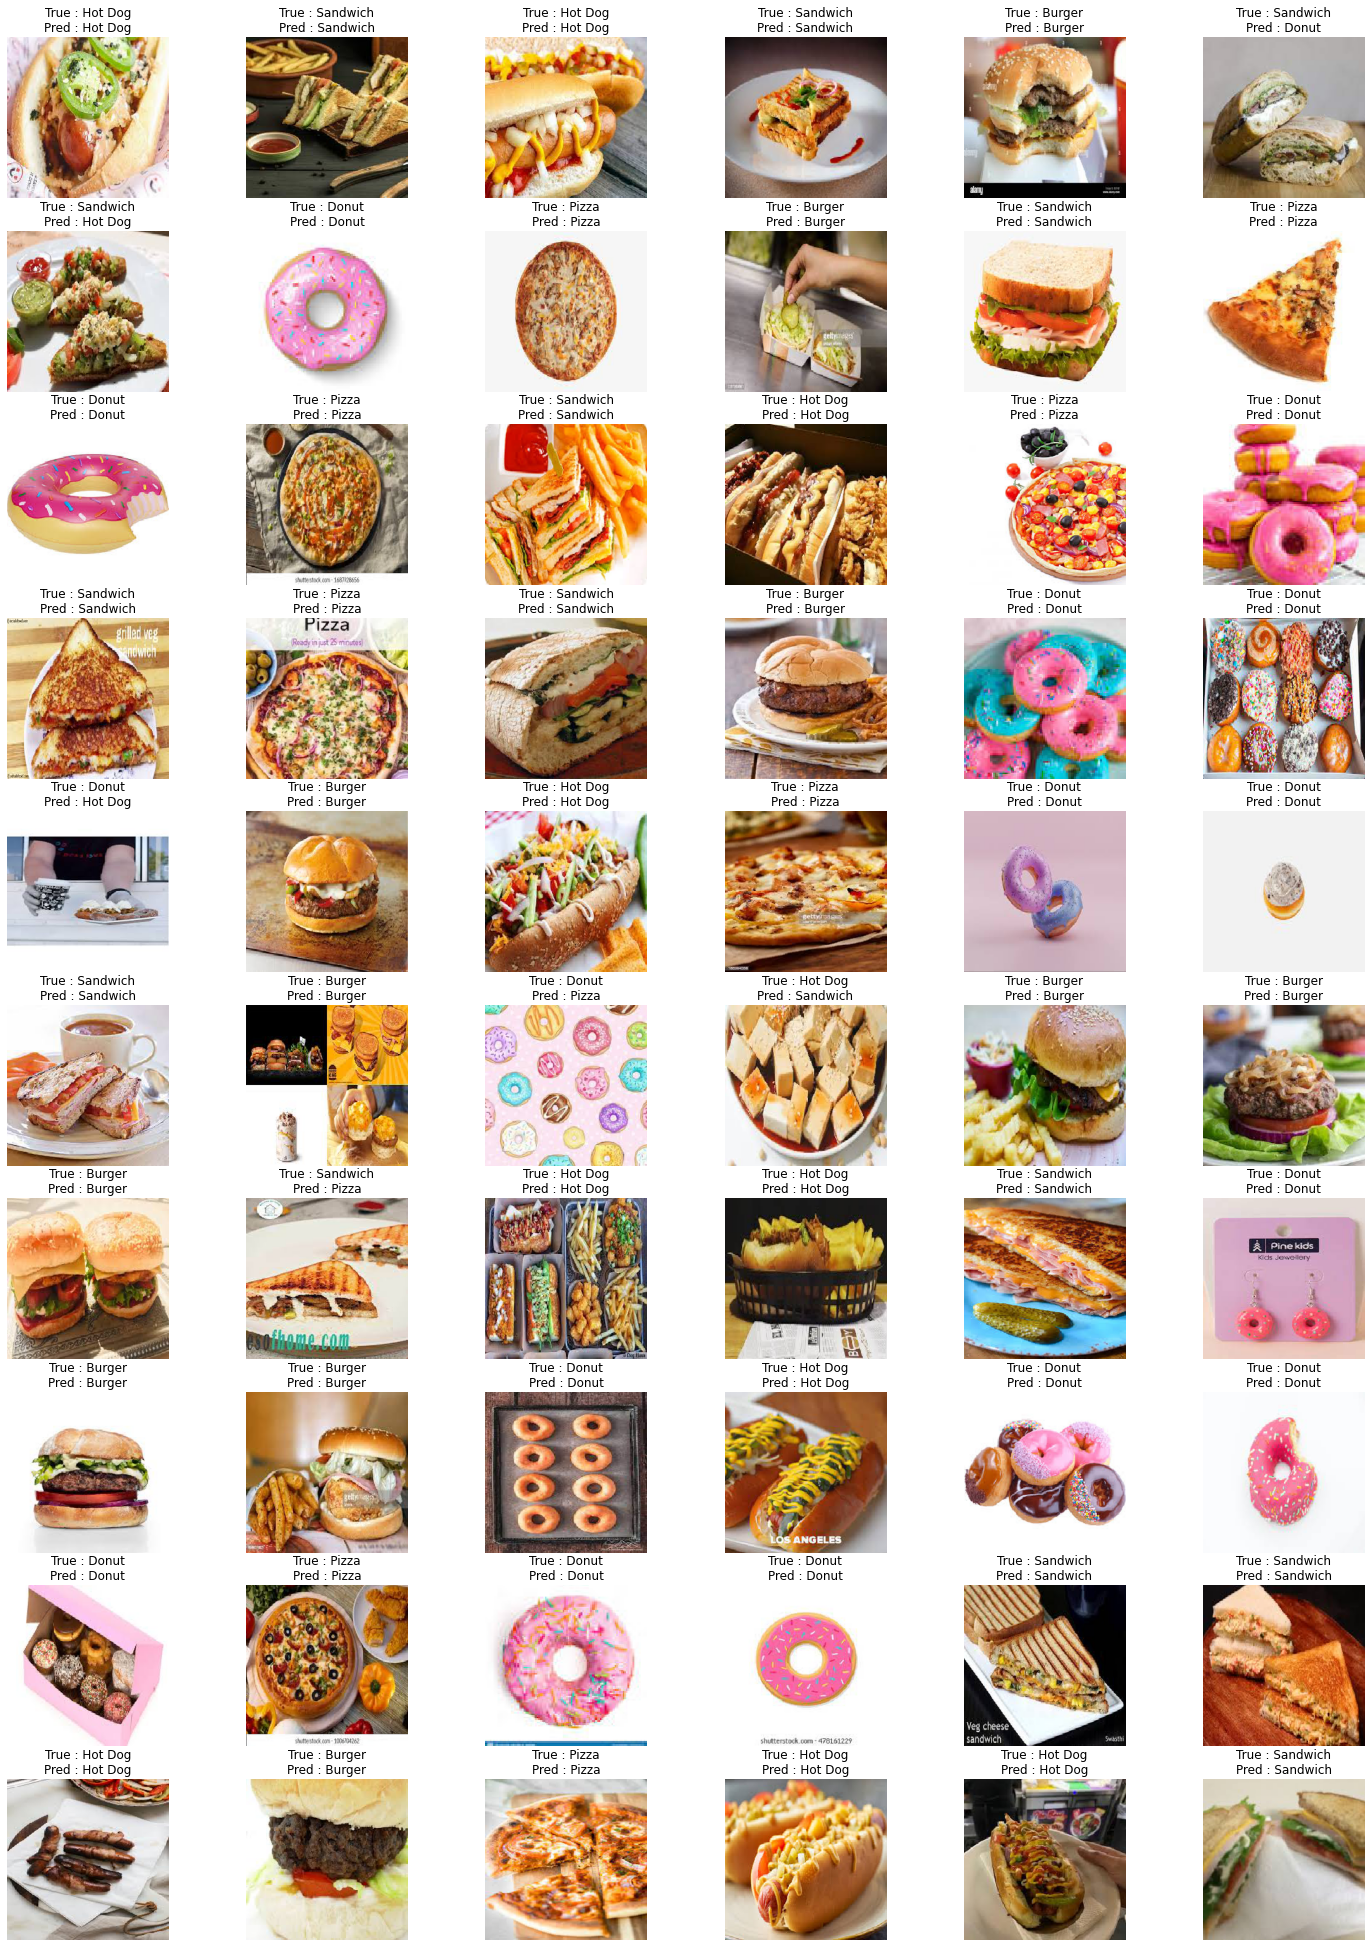

In [17]:
show_images(data=valid_ds, model=model, GRID=[10,6], figsize=(25,35))

The model made a few errors, like it **classified a Sandwich as Burger**. But if you look at the image, you will find that the **features of that image for being sandwich is relatively lower than the features for being burger**. What I found that whenever the **model prediction** does **not matches** with the **actual class**, the image is skewed.

---
**DeepNets**